<center><img src='https://www.datahack.es/wp-content/uploads/2020/02/logo-home.png' width="500"></center>

## Ejercicio de modelos de clasificación 4 PUNTOS <font color="Grey"> Luis Blanco
En este ejercicio vamos a trabajar con un dataset de datos de churn de una empresa de telecomunicaciones.





<center><img src='https://camo.githubusercontent.com/ce0e68448300bcf34e8eb696c79f3269a3e7e264/68747470733a2f2f343667796e36317a34693074317531706e713262626b32652d7770656e67696e652e6e6574646e612d73736c2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031372f30372f637573746f6d65722d636875726e2d656469742e6a706567' width=600 ></center>

## Dataset
Toda la información necesaria sobre el dataset la puedes encontrar aquí:
https://www.kaggle.com/blastchar/telco-customer-churn


## Pasos a seguir

1. Descarga la información del churn en una carpeta que se llame `datos_ejercicios/clasificacion`.

2. Lee el fichero csv .

3. Realiza un análisis exploratorio de los datos que te ayude a entender el dataset. Si necesitas, puedes recurrir al uso de gráficos.

4. Divide el modelo en train y test.

5. Prueba las predicciones de los distintos modelos que ofrece Spark Mllib.

6. ¿Se pueden mejorar los resultado haciendo tunning de los hiperparámetros? Demuestralo

7. En base al tipo de problemática (modelo de churn) con qué modelo te quedarías. Justificalo

8. Descarga el ipynb, conviertelo a html y esos serán tus documentos de evaluación.

# <font color="grey">0. Instalaciones y librerías:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<font color="grey"> Instalación de Spark, Findspark y Pyspark.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 71kB/s 
     |████████████████████████████████| 204kB 34.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=c17c46128e200ec60f489d0fe6e87f62c6269ae019baa3dbb12dadbfbe44e08b
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


<font color="Grey">Creación de la Sesión Spark "ejercicio_modelos_clasificacion".

In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ejercicio_modelos_clasificacion").master("local[*]").getOrCreate()

<font color="Grey">Instalación y carga de librerías:

In [4]:
#Carga de datos de la web, no lo usamos en esta práctica (ejemplo):
#!pip install wget 
#import wget

#Tratamiento de datos:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import (OneHotEncoderEstimator, StringIndexer,
                                VectorAssembler, VectorIndexer, IndexToString)
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
import itertools

#Dibujo de tablas y gráficos:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50) #max 50 rows out

#Modelos de Clasificación:
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier
                                       ,RandomForestClassifier, GBTClassifier,
                                       MultilayerPerceptronClassifier, LinearSVC,
                                       NaiveBayes,OneVsRest)

#Evaluadores y métricas:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import (confusion_matrix, precision_score,
                             recall_score, accuracy_score,f1_score)

#Mejora de Entrenamiento y Modelos:
from sklearn.model_selection import StratifiedShuffleSplit
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Variable con el valor de la semilla para todos los random_state que se realicen:
random_state=23 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <font color="grey">1. Descarga la información del churn en una carpeta que se llame `datos_ejercicios/clasificacion`.

<font color="grey">Nosotros ya tenemos los datos de Churn_telco descargados y subidos a drive para poder usarlo en Google Colab.  
Un ejemplo de descarga sería el siguiente:

In [0]:
#url= "https://www.kaggle.com/blastchar/telco-customer-churn/download"
#wget.download(url, "/content/drive/My Drive/Colab Notebooks/Práctica Spark/datos_ejercicios/clasificacion")

# <font color="grey">2. Lee el fichero csv.

In [0]:
df = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Práctica Spark/datos_ejercicios/clasificacion/telco_churn.csv",header=True, inferSchema = True).cache()

In [7]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



<font color="Grey">Vemos que la feature "TotalCharges" no se ha tipificado correctamente, ya que indica que es string. Vamos a castearla como double.

In [8]:
df=df.withColumn("TotalCharges", df["TotalCharges"].cast("double"))
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



# <font color="Grey">3. Realiza un análisis exploratorio de los datos que te ayude a entender el dataset. Si necesitas, puedes recurrir al uso de gráficos.

In [9]:
#Trasponemos los datos para ver más claramente los datos de cada columna (ahora filas)
pd.DataFrame(df.take(5),columns=df.columns).transpose()

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


<font color="Grey"> **FEATURES**  
<font color="Grey">- customerID: identificador del cliente.  
<font color="Grey">- gender: sexo (male o female).   
<font color="Grey">- SeniorCitizen: jubilado/a o no (1, 0).  
<font color="Grey">- Partner: si tiene pareja (Yes, No).  
<font color="Grey">- Dependents: si el cliente tiene familiares (Yes, No).  
<font color="Grey">- tenure: número de meses que es cliente.  
<font color="Grey">- PhoneService: si el cliente tiene o no servicio telefónico (Yes, No).  
<font color="Grey">- MultipleLines: si el cliente tiene más de una línea o no (Yes, No, No phone service).  
<font color="Grey">- InternetService: tipo de servicio de internet contratado(DSL, Fiber optic, No).  
<font color="Grey">- OnlineSecurity: si el cliente tiene servicio de seguridad online (Yes, No, No internet service).  
<font color="Grey">- OnlineBackup: si el cilente tiene servicio de backup online (Yes, No, No internet service).  
<font color="Grey">- DeviceProtection: si el cliente tiene servicio de protección del dispositivo (Yes, No, No internet service).  
<font color="Grey">- TechSupport: si el cliente tiene soporto técnico (Yes, No, No internet service).  
<font color="Grey">- StreamingTV: si el cliente tiene contratado TV en streaming (Yes, No, No internet service).  
<font color="Grey">- StreamingMovies: si el cliente tiene contratado Películas en streaming (Yes, No, No internet service).  
<font color="Grey">- Contract: tipo de contrato (Month-to-month, One year, Two year).  
<font color="Grey">- PaperlessBilling: si el cliente tiene facturación electrónica (Yes, No).  
<font color="Grey">- PaymentMethod: método de pago (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).  
<font color="Grey">- MonthlyCharges: importe mensual facturado.  
<font color="Grey">- TotalCharges: total facturado al cliente.  

---
<font color="Grey"> **LABEL**  
<font color="Grey">- Churn: pérdida de cliente (Yes, No).

In [10]:
df.toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


<font color="Grey">Vamos a ver cómo de balanceada está nuestra label "Churn":

In [11]:
df.groupBy("Churn").count().toPandas()

,Churn,count
0,No,5174
1,Yes,1869


<font color="Grey">Nuestra label está muy desbalanceada, por lo que tenemos que tenerlo en cuenta a la hora de hacer nuestro modelo y ver sus resultados.  
Vamos a ver si tenemos nulos o duplicados:

In [0]:
df_pandas=df.toPandas()

In [13]:
df_pandas.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [14]:
df_pandas["customerID"].describe()

count           7043
unique          7043
top       9710-ZUSHQ
freq               1
Name: customerID, dtype: object

<font color="Grey">Vemos que no tenemos duplicados, ya que "customerID" tiene todos sus registros como únicos. Por otro lado, la feature "TotalCharges" tiene 11 valores nulos, vamos a analizarlos.

In [0]:
nan_rows = df_pandas[df_pandas.isnull().any(1)]

In [16]:
nan_rows

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


<font color="Grey">Vemos que todos los nulos corresponden con clientes nuevos, es decir, es imposible que hayan podido realizar algún pago. Vamos a comprobar si existe algún valor de "tenure" igual a 0 que no contenga valor nulo en "TotalChargers". Si no existe ningún valor más, damos por hecho que es debido exclusivamente a que se les ha facturado 0, por lo que cambiaremos los nulos por 0.

In [17]:
df_pandas[df_pandas["tenure"]==0].count()

customerID          11
gender              11
SeniorCitizen       11
Partner             11
Dependents          11
tenure              11
PhoneService        11
MultipleLines       11
InternetService     11
OnlineSecurity      11
OnlineBackup        11
DeviceProtection    11
TechSupport         11
StreamingTV         11
StreamingMovies     11
Contract            11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges         0
Churn               11
dtype: int64

<font color="Grey">Vemos que todos los valores de "tenure"==0, son los nulos en TotalCharges, por lo que vamos a eliminarlos.

In [0]:
df_pandas["TotalCharges"].fillna(0,inplace=True)

In [19]:
df_pandas[df_pandas.isnull().any(1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [20]:
df_pandas[df_pandas["tenure"]==0].count()

customerID          11
gender              11
SeniorCitizen       11
Partner             11
Dependents          11
tenure              11
PhoneService        11
MultipleLines       11
InternetService     11
OnlineSecurity      11
OnlineBackup        11
DeviceProtection    11
TechSupport         11
StreamingTV         11
StreamingMovies     11
Contract            11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
Churn               11
dtype: int64

In [0]:
df_clean=spark.createDataFrame(df_pandas).cache()

In [22]:
df_clean.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

<font color="Grey">Ya tenemos nuestro dataframe sin nulos y lo hemos incluido en cache.  
Vamos a analizar los datos, para ello, debemos transformar nuestros registros categóricos en numéricos. Aunque no sería necesario en todos los modelos (lo modelos de árboles permiten usar registros categóricos), como vamos a probar varios de ellos, pasaremos todo a numérico.  
Para ello, vamos a generar un pipeline con los procesos de transformación, que serán:  
<font color="Grey">- Indexar las features categóricas.  
<font color="Grey">- Codificar con One Hot Encoder.  
<font color="Grey">- Generar el vector feature y label.

In [23]:
df_clean.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'bigint'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'bigint'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

<font color="Grey">Nuestras features categóricas son todas, excepto 'customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges' y 'TotalCharges'. 'Churn' es nuestra label, que trataremos a parte.

In [0]:
columnas=df_clean.columns

In [25]:
columnas

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [0]:
categoricas=df_clean.columns
categoricas.remove("customerID") #Es el Id del cliente.
categoricas.remove("SeniorCitizen") #Ya está categorizada.
categoricas.remove("tenure") #Es numérica.
categoricas.remove("MonthlyCharges") #Es numérica.
categoricas.remove("TotalCharges") #Es numérica.
categoricas.remove("Churn") #Es nuestra label, la trataremos a parte.

In [27]:
categoricas

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

<font color="Grey">Vamos a crear una lista con las etapas de transformación de nuestros datos, que será lo que incluyamos en nuestro pipeline.  
En primer lugar realizaremos la indexación con String Indexer y luego el codificado con One Hot Encoder.

In [0]:
stages=[]
for i in categoricas:
    categorical_stringIndexer = StringIndexer(inputCol = i, outputCol = i + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[categorical_stringIndexer.getOutputCol()], outputCols=[i + "vector_class"])
    stages += [categorical_stringIndexer, encoder]

In [29]:
print(len(stages))
stages

30


[StringIndexer_d45ece611f35,
 OneHotEncoderEstimator_5f87385bb9d8,
 StringIndexer_ef4d90a82e91,
 OneHotEncoderEstimator_c038d1e70a46,
 StringIndexer_119a4ea1f5c3,
 OneHotEncoderEstimator_293bcbb3c800,
 StringIndexer_c3c09565fb0d,
 OneHotEncoderEstimator_f270f4499b90,
 StringIndexer_823f35350adc,
 OneHotEncoderEstimator_cc64b92e52a2,
 StringIndexer_c2875884b685,
 OneHotEncoderEstimator_30b0f29c5bd2,
 StringIndexer_178d7200198c,
 OneHotEncoderEstimator_ee73bf0d7777,
 StringIndexer_4ea072773a89,
 OneHotEncoderEstimator_75261b14bc92,
 StringIndexer_ffbb220f6fe6,
 OneHotEncoderEstimator_7c8e9e13fb36,
 StringIndexer_6c3064e578b3,
 OneHotEncoderEstimator_acac6491dfed,
 StringIndexer_f316373259eb,
 OneHotEncoderEstimator_ce6b2636e0a0,
 StringIndexer_9b8325dc8a04,
 OneHotEncoderEstimator_a1d19e77aea1,
 StringIndexer_605a14f27fb4,
 OneHotEncoderEstimator_4de258a43547,
 StringIndexer_e774de868d2a,
 OneHotEncoderEstimator_55da2a136882,
 StringIndexer_698cbe7c68d3,
 OneHotEncoderEstimator_73d3b28fd

<font color="Grey">Ahora vamos a juntar nuestras variables categóricas ya codificadas con las numéricas. Pero, primero vamos a definir las variables numéricas y comprobaremos su correlación por si podemos eliminar alguna de ellas:

In [0]:
valores_numericos= [i[0] for i in df_clean.dtypes if i[1] =="bigint" or i[1] =="double"]

In [31]:
valores_numericos

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

<font color="Grey">Vemos que aparece la feature "SeniorCitizen", aunque es catégorica, vamos a dejarla, sin tenerla en cuenta en este análisis, ya que luego usaremos la variable valores_numéricos en el ensamblaje junto con el reto de categóricas. Si fuese necesario eliminar alguna variable numérica por correlación alta, la eliminaríamos de esta lista.

In [32]:
df_clean.select(valores_numericos).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
SeniorCitizen,7043,0.1621468124378816,0.368611605610013,0,1
tenure,7043,32.37114865824223,24.559481023094474,0,72
MonthlyCharges,7043,64.76169246059925,30.09004709767848,18.25,118.75
TotalCharges,7043,2279.7343035638205,2266.7944696890213,0.0,8684.8


In [0]:
datos_numericos= df_clean.select(valores_numericos).toPandas()

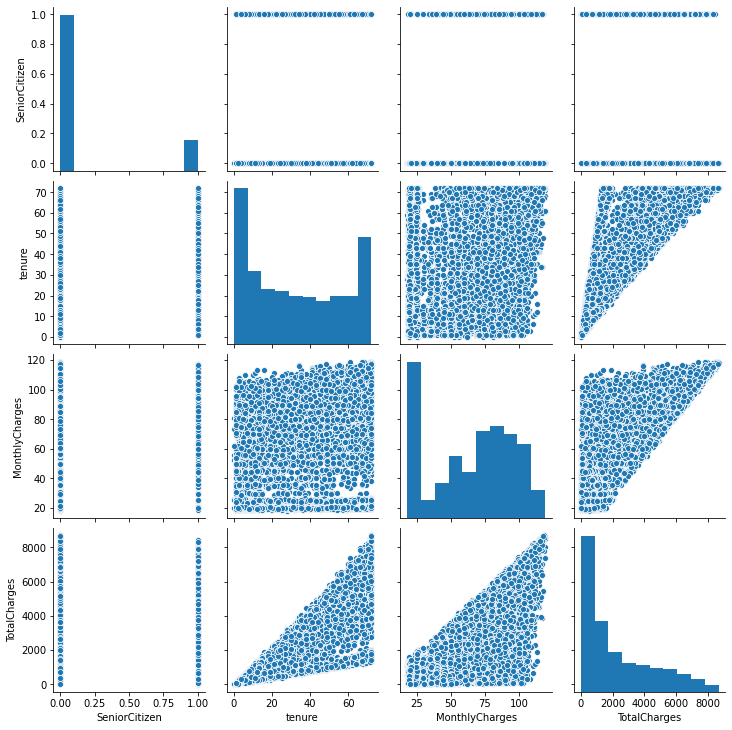

In [34]:
sns.pairplot(datos_numericos);

In [35]:
matriz_corr= datos_numericos.corr()
matriz_corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
MonthlyCharges,0.220173,0.247900,1.000000,0.651174
TotalCharges,0.103006,0.826178,0.651174,1.000000


<font color="Grey">Vamos a crear un mapa de calor para verlo más claramente (realmente no sería necesario ya que tenemos pocas variables y se ve claro, pero queda muy bonito...)

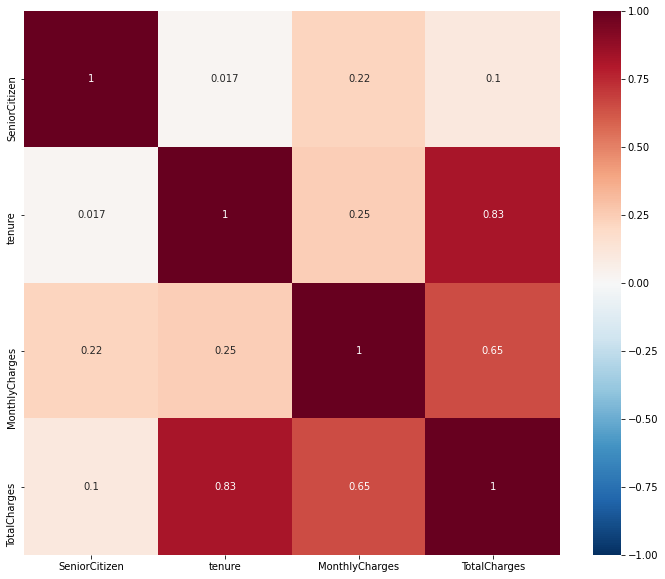

In [36]:
plt.figure(figsize=(12,10))
sns.heatmap(matriz_corr,
            vmin=-1.0,
            vmax=1.0,
            annot=True,
            cmap="RdBu_r");

<font color="Grey">Vemos una alta correlación entre "ternure" y "TotalCharges", es normal, ya que cuanto más meses lleve el cliente, mayor será lo que se le ha facturado.  
Por otro lado, tampoco es excesivamente alta, por lo que mantendremos todas nuestras columnas numéricas.  
Vamos a realizar el ensamble de las features numéricas y "SeniorCitizen" con nuestras variables categóricas.

In [0]:
assemblerInputs= [i+"vector_class" for i in categoricas]+valores_numericos

<font color="Grey">Ahora vamos a juntar todas las features en un único vector que llamaremos "features" y lo incluiremos como una etapa más que agregar a nuestro pipeline.

In [0]:
assembler= VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

<font color="Grey">Vamos a pasar un String Indexer por nuestra label, para convertirla en numérica y al igual que antes, lo incluimos como otra etapa de nuestro pipeline.

In [0]:
label_stringIdx= StringIndexer(inputCol="Churn", outputCol="label")
stages += [label_stringIdx]

In [40]:
print(len(stages))
stages

32


[StringIndexer_d45ece611f35,
 OneHotEncoderEstimator_5f87385bb9d8,
 StringIndexer_ef4d90a82e91,
 OneHotEncoderEstimator_c038d1e70a46,
 StringIndexer_119a4ea1f5c3,
 OneHotEncoderEstimator_293bcbb3c800,
 StringIndexer_c3c09565fb0d,
 OneHotEncoderEstimator_f270f4499b90,
 StringIndexer_823f35350adc,
 OneHotEncoderEstimator_cc64b92e52a2,
 StringIndexer_c2875884b685,
 OneHotEncoderEstimator_30b0f29c5bd2,
 StringIndexer_178d7200198c,
 OneHotEncoderEstimator_ee73bf0d7777,
 StringIndexer_4ea072773a89,
 OneHotEncoderEstimator_75261b14bc92,
 StringIndexer_ffbb220f6fe6,
 OneHotEncoderEstimator_7c8e9e13fb36,
 StringIndexer_6c3064e578b3,
 OneHotEncoderEstimator_acac6491dfed,
 StringIndexer_f316373259eb,
 OneHotEncoderEstimator_ce6b2636e0a0,
 StringIndexer_9b8325dc8a04,
 OneHotEncoderEstimator_a1d19e77aea1,
 StringIndexer_605a14f27fb4,
 OneHotEncoderEstimator_4de258a43547,
 StringIndexer_e774de868d2a,
 OneHotEncoderEstimator_55da2a136882,
 StringIndexer_698cbe7c68d3,
 OneHotEncoderEstimator_73d3b28fd

<font color="Grey">Creamos nuestro pipeline, lo entrenamos y lo transformamos en dataframe.

In [0]:
pipeline= Pipeline(stages=stages)
pipelineModel= pipeline.fit(df_clean)
df_clean= pipelineModel.transform(df_clean)

In [42]:
#Prueba
df_clean.toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,genderIndex,gendervector_class,PartnerIndex,Partnervector_class,DependentsIndex,Dependentsvector_class,PhoneServiceIndex,PhoneServicevector_class,MultipleLinesIndex,MultipleLinesvector_class,InternetServiceIndex,InternetServicevector_class,OnlineSecurityIndex,OnlineSecurityvector_class,OnlineBackupIndex,OnlineBackupvector_class,DeviceProtectionIndex,DeviceProtectionvector_class,TechSupportIndex,TechSupportvector_class,StreamingTVIndex,StreamingTVvector_class,StreamingMoviesIndex,StreamingMoviesvector_class,ContractIndex,Contractvector_class,PaperlessBillingIndex,PaperlessBillingvector_class,PaymentMethodIndex,PaymentMethodvector_class,features,label
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1.0,(0.0),1.0,(0.0),0.0,(1.0),1.0,(0.0),2.0,"(0.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.0,(1.0),0.0,(1.0),0.0,(1.0),0.0,(1.0),0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",2.0,"(0.0, 0.0)",1.0,(0.0),1.0,"(0.0, 1.0, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.0,(1.0),0.0,(1.0),0.0,(1.0),0.0,(1.0),0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),1.0,"(0.0, 1.0, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.0,(1.0),0.0,(1.0),0.0,(1.0),1.0,(0.0),2.0,"(0.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",2.0,"(0.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1.0,(0.0),0.0,(1.0),0.0,(1.0),0.0,(1.0),0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0.0,(1.0),1.0,(0.0),1.0,(0.0),0.0,(1.0),1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",2.0,"(0.0, 0.0)",0.0,(1.0),1.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,1.0,(0.0),1.0,(0.0),1.0,(0.0),0.0,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",2.0,"(0.0, 0.0)",0.0,(1.0),3.0,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No

In [43]:
selectedCols = ['label', 'features'] + columnas
df= df_clean.select(selectedCols)
df.show()

+-----+--------------------+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|label|            features|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+-----+--------------------+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+

# <font color="Grey">4. Divide el modelo en train y test.

<font color="Grey">Como tenemos muy desbalanceada la label, vamos a dividir nuestro dataframe en train y test manteniendo su porcentaje sobre el total.  
Para ello, pasaremos nuestro dataframe a Pandas, usaremos la función StratifiedShuffleSplit

In [44]:
df=df.toPandas()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)
for train_index, test_index in sss.split(df, df["label"]):
    train = df.loc[train_index]
    test = df.loc[test_index]

df=spark.createDataFrame(df)
train=spark.createDataFrame(train)
test=spark.createDataFrame(test)
print("El conjunto de train tiene:",train.count(),"registros")
print("El conjunto de test tiene:",test.count(),"registros")
print("Total de registros:",train.count()+test.count())

El conjunto de train tiene: 5282 registros
El conjunto de test tiene: 1761 registros
Total de registros: 7043


<font color="Grey">Vamos a comprobar que se han mantenido los porcentajes de nuestra label en el mismo rango que en nuestro dataframe original.

In [45]:
df.groupBy("label").count().toPandas()

,label,count
0,0.0,5174
1,1.0,1869


In [46]:
print("El porcentaje de Yes en todo el dataframe es:", str((1869/5174)*100)+"%")

El porcentaje de Yes en todo el dataframe es: 36.122922303826826%


In [47]:
train.groupBy("label").count().toPandas()

,label,count
0,0.0,3880
1,1.0,1402


In [48]:
print("El porcentaje de Yes en train es:", str((1402/3880)*100)+"%")

El porcentaje de Yes en train es: 36.1340206185567%


In [49]:
test.groupBy("label").count().toPandas()

,label,count
0,0.0,1294
1,1.0,467


In [50]:
print("El porcentaje de Yes en train es:", str((467/1294)*100)+"%")

El porcentaje de Yes en train es: 36.08964451313756%


<font color="Grey">Comprobamos que sí se ha mantenido el mismo porcentaje de datos.

# <font color="grey">5. Prueba las predicciones de los distintos modelos que ofrece Spark Mllib.

<font color="Grey">Los modelos de clasificación que ofrece Spark MLlib son:  
<font color="Grey">a. Logistic regression  
<font color="Grey">b. Decision tree classifier  
<font color="Grey">c. Random forest classifier  
<font color="Grey">d. Gradient-boosted tree classifier  
<font color="Grey">e. Naive Bayes  
<font color="Grey">f. Linear Support Vector Machine  

<font color="Grey">No los vamos a usar:  
<font color="Grey">- One-vs-Rest classifier (a.k.a. One-vs-All)  
<font color="Grey">- Multilayer perceptron classifier

<font color="Grey">Para analizar los resultados vamos a calcular el Área Bajo la Curva PR y la matriz de confusión y sus métricas.
*El área bajo la curva ROC, al tener desbalanceada la label, no es representativo, por eso hemos optado por el área bajo la curva PR, que tienen en cuenta la precisión de las predicciones.

<font color="Grey">Vamos a sacar las métricas de: Precisión, Recall y Accuracy:

<center><img src='https://www.juanbarrios.com/wp-content/uploads/2019/07/matriz4.jpg' title="Métricas Matriz de Confusión" width="500"></center>

<font color="Grey">**Accuracy**: proporción entre los positivos reales predichos por el algoritmo y todos los casos positivos.

<font color="Grey">**Precision**: proporción entre el número de predicciones correctas (tanto positivas como negativas) y el total de predicciones.

<font color="Grey">**Recall**: proporción de casos positivos que fueron correctamente identificadas por el algoritmo.

<font color="Grey">Al tener muy desbalanceada nuestra label, la mejor métrica para analizar nuestros modelos es el F1_score, ya que relaciona tanto el Recall como Precision:  

<font color="Grey">$$2*\frac{Recall * Precision}{Recall + Precision}$$

<center> <font color="Grey">
*Imagen e info: https://www.juanbarrios.com/matriz-de-confusion-y-sus-metricas/</center>

<font color="Grey">Por ello, vamos a definir la función para plotear la matriz de confusión (plot_confusion_matrix) y la función que nos muestre nuestra matriz de confusión para nuestro modelo (sacar_confusion_matrix). Para ello, será necesario que definamos las clases que incluiremos en nuestra función con los valores predichos de nuestra predicción.

In [0]:
#Función para plotear la función

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plotea nuestra matriz de confusión.
    Si hemos normalizado nuestro dataframe, hay que incluir en
    setting "normalize=True".
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
#Función para sacar la matriz de confusión de nuestro modelo
def sacar_confusion_matrix(predictions):
    """
    Función para dibujar la matriz de confusión e imprimir
    "Precision", "Recall", "F1" y "Accuracy Score".
    """
    y_true = predictions.select("label")
    y_true = y_true.toPandas()

    y_pred = predictions.select("prediction")
    y_pred = y_pred.toPandas()

    cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
    cnf_matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_temp,
                          title='Confusion matrix, without normalization')
    plt.show()

    precision = precision_score(y_true, y_pred)
    print('Precision: %.4f' % precision)

    recall = recall_score(y_true, y_pred)
    print('Recall: %.4f' % recall)  

    F1 = f1_score(y_true, y_pred)
    print('F1: %.4f' % F1)  

    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy score: {0:0.4f}'.format(accuracy))

<font color="Grey">Para evaluar nuestro modelo utilizaremos "BinaryClassificationEvaluator", usando como métrica "areaUnderPR" en lugar de "areaUnderRoc", ya que tenemos la label desbalanceada. De esta forma, el área calculada bajo la curva tendra como ejes:
- <font color="Grey">TPR: cuántos casos positivos se han clasificado correctamente de todos los casos positivos en los datos.</font>
- <font color="Grey">Precisión: cuántos positivos verdaderos de todos los que se han *predicho* como positivos.  

<font color="Grey">El uso de este evaluador, tendrá más sentido cuando realicemos Cross Validation, ya que será el evaluador que tendrá en cuenta para entrenar el modelo.

<font color="Grey">Aunque, como hemos dicho anteriormente, la métrica principal en la que nos fijaremos es F1 Score.

In [0]:
#Para todos nuestros modelos, el evaluator será:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")



<font color="Grey">En esta primera parte del ejercicio, probaremos los modelos con los hiperparámetros por defecto:

In [54]:
#Logistic Regression:
lr=LogisticRegression(featuresCol="features", labelCol="label")
lr_model=lr.fit(train)
lr_predictions=lr_model.transform(test)
lr_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[6.819034409130658, -6.819034409130658]","[0.9989084172678218, 0.0010915827321783022]"
1,8756-RDDLT,0.0,0.0,"[2.958450174408604, -2.958450174408604]","[0.9506613511108949, 0.049338648889105115]"
2,3190-ITQXP,0.0,0.0,"[5.531882517622714, -5.531882517622714]","[0.9960570781070565, 0.003942921892943432]"
3,4672-FOTSD,0.0,0.0,"[1.2938909589084984, -1.2938909589084984]","[0.7848050461810017, 0.21519495381899834]"
4,2958-NHPPS,0.0,0.0,"[2.398603864169671, -2.398603864169671]","[0.9167207791954027, 0.08327922080459717]"
5,3030-YDNRM,0.0,1.0,"[-0.7665871110909197, 0.7665871110909197]","[0.31721784465256236, 0.6827821553474377]"
6,8777-PVYGU,0.0,0.0,"[3.1081114979602606, -3.1081114979602606]","[0.9572260991303827, 0.04277390086961742]"
7,7622-FWGEW,0.0,0.0,"[3.861865355268816, -3.861865355268816]","[0.9794043633729573, 0.020595636627042644]"
8,8129-GMVGI,0.0,0.0,"[6.061293288663659, -6.061293288663659]","[0.9976740389232005, 0.0023259610767994267]"
9,7315-WYOAW,0.0,1.0,"[-0.3271939225605076, 0.3271939225605076]","[0.41892354125395037, 0.5810764587460496]"


In [55]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(lr_predictions)))

Área bajo la curva ROC en Test: 0.6255244256370106


Confusion matrix, without normalization
[[1146  148]
 [ 211  256]]


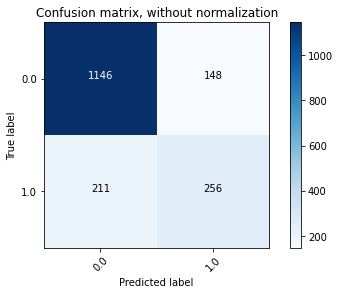

Precision: 0.6337
Recall: 0.5482
F1: 0.5878
Accuracy score: 0.7961


In [56]:
#Lista con las clases
class_temp = lr_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lr_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.146 Verdaderos Negativos y 256 Verdaderos Positivos, sin embargo ha errado en 211 Falsos Negativos y 148 Falsos Positivos. El F1 Score es 0.5878.

Confusion matrix, without normalization
[[3490  390]
 [ 615  787]]


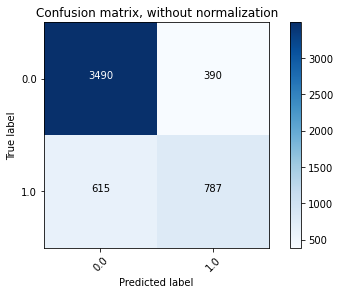

Precision: 0.6686
Recall: 0.5613
F1: 0.6103
Accuracy score: 0.8097


In [112]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
lr_predictions_train = lr_model.transform(train)

#Lista con las clases
class_temp = lr_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lr_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [57]:
#Decision Tree Classifier:
dt=DecisionTreeClassifier(featuresCol="features",labelCol="label",seed=random_state)
dt_model=dt.fit(train)
dt_predictions=dt_model.transform(test)
dt_predictions.select("customerID","label","prediction","rawPrediction","probability").show(10)

+----------+-----+----------+--------------+--------------------+
|customerID|label|prediction| rawPrediction|         probability|
+----------+-----+----------+--------------+--------------------+
|6980-IMXXE|  0.0|       0.0|[2231.0,164.0]|[0.93152400835073...|
|8756-RDDLT|  0.0|       0.0|  [103.0,38.0]|[0.73049645390070...|
|3190-ITQXP|  0.0|       0.0|[2231.0,164.0]|[0.93152400835073...|
|4672-FOTSD|  0.0|       0.0|  [506.0,89.0]|[0.85042016806722...|
|2958-NHPPS|  0.0|       0.0|  [506.0,89.0]|[0.85042016806722...|
|3030-YDNRM|  0.0|       1.0| [199.0,375.0]|[0.34668989547038...|
|8777-PVYGU|  0.0|       0.0|[2231.0,164.0]|[0.93152400835073...|
|7622-FWGEW|  0.0|       0.0|[2231.0,164.0]|[0.93152400835073...|
|8129-GMVGI|  0.0|       0.0|[2231.0,164.0]|[0.93152400835073...|
|7315-WYOAW|  0.0|       1.0| [199.0,375.0]|[0.34668989547038...|
+----------+-----+----------+--------------+--------------------+
only showing top 10 rows



In [58]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(dt_predictions)))

Área bajo la curva ROC en Test: 0.4234356843430189


Confusion matrix, without normalization
[[1085  209]
 [ 184  283]]


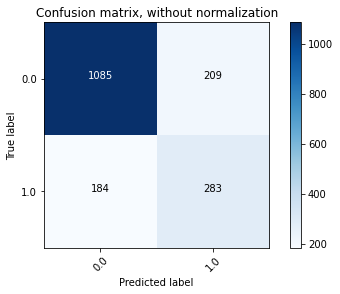

Precision: 0.5752
Recall: 0.6060
F1: 0.5902
Accuracy score: 0.7768


In [59]:
#Lista con las clases
class_temp = dt_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(dt_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.085 Verdaderos Positivos y 283 Verdaderos Negativos, sin embargo ha errado en 184 Falsos Positivos y 209 Falsos Negativos. El F1 Score es 0.5902.

Confusion matrix, without normalization
[[3344  536]
 [ 498  904]]


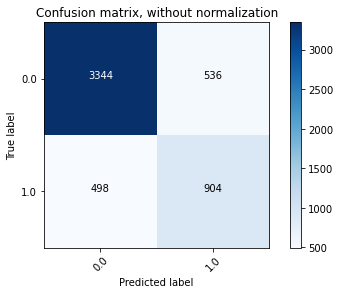

Precision: 0.6278
Recall: 0.6448
F1: 0.6362
Accuracy score: 0.8042


In [113]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
dt_predictions_train = dt_model.transform(train)

#Lista con las clases
class_temp = dt_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(dt_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [60]:
#Random Forest Classifier:
rf = RandomForestClassifier(featuresCol="features",labelCol="label",seed=random_state)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_predictions.select("customerID","label","prediction","rawPrediction","probability").show(10)

+----------+-----+----------+--------------------+--------------------+
|customerID|label|prediction|       rawPrediction|         probability|
+----------+-----+----------+--------------------+--------------------+
|6980-IMXXE|  0.0|       0.0|[18.8869540531172...|[0.94434770265586...|
|8756-RDDLT|  0.0|       0.0|[16.0091081533903...|[0.80045540766951...|
|3190-ITQXP|  0.0|       0.0|[18.8869540531172...|[0.94434770265586...|
|4672-FOTSD|  0.0|       0.0|[16.3689383866154...|[0.81844691933077...|
|2958-NHPPS|  0.0|       0.0|[16.5813084787783...|[0.82906542393891...|
|3030-YDNRM|  0.0|       1.0|[7.26675817691146...|[0.36333790884557...|
|8777-PVYGU|  0.0|       0.0|[17.8953000018703...|[0.89476500009351...|
|7622-FWGEW|  0.0|       0.0|[18.5044857394624...|[0.92522428697312...|
|8129-GMVGI|  0.0|       0.0|[18.8869540531172...|[0.94434770265586...|
|7315-WYOAW|  0.0|       0.0|[11.4502364679294...|[0.57251182339647...|
+----------+-----+----------+--------------------+--------------

In [61]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(rf_predictions)))

Área bajo la curva ROC en Test: 0.6097589810900638


Confusion matrix, without normalization
[[1206   88]
 [ 291  176]]


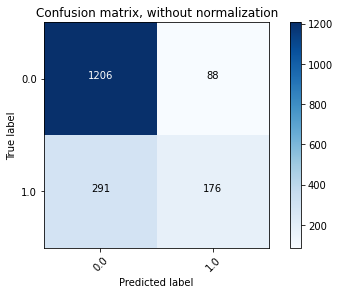

Precision: 0.6667
Recall: 0.3769
F1: 0.4815
Accuracy score: 0.7848


In [62]:
#Lista con las clases
class_temp = rf_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(rf_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.206 Verdaderos Negativos y 176 Verdaderos Positivos, sin embargo ha errado en 291 Falsos Negativos y 88 Falsos Positivos. El F1 Score es 0.4815.

Confusion matrix, without normalization
[[3631  249]
 [ 785  617]]


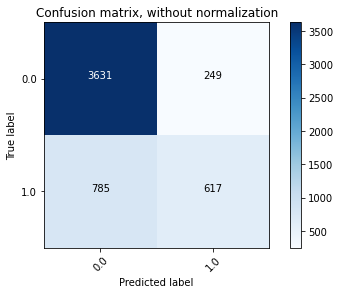

Precision: 0.7125
Recall: 0.4401
F1: 0.5441
Accuracy score: 0.8042


In [114]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
rf_predictions_train = rf_model.transform(train)

#Lista con las clases
class_temp = rf_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(rf_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [63]:
#Gradient Boosting Tree Classifier
gbt=GBTClassifier(featuresCol="features",labelCol="label",seed=random_state)
gbt_model=gbt.fit(train)
gbt_predictions=gbt_model.transform(test)
gbt_predictions.select("customerID","label","prediction","rawPrediction","probability").show(10)

+----------+-----+----------+--------------------+--------------------+
|customerID|label|prediction|       rawPrediction|         probability|
+----------+-----+----------+--------------------+--------------------+
|6980-IMXXE|  0.0|       0.0|[1.50978385464000...|[0.95345034297905...|
|8756-RDDLT|  0.0|       0.0|[0.62595473386875...|[0.77763022415469...|
|3190-ITQXP|  0.0|       0.0|[1.50113920164482...|[0.95267695140090...|
|4672-FOTSD|  0.0|       0.0|[0.97033604962701...|[0.87442596205071...|
|2958-NHPPS|  0.0|       0.0|[1.18065865827640...|[0.91382959424905...|
|3030-YDNRM|  0.0|       1.0|[-0.1597198886740...|[0.42081228446850...|
|8777-PVYGU|  0.0|       0.0|[1.34568995203699...|[0.93651607152824...|
|7622-FWGEW|  0.0|       0.0|[1.37418012758872...|[0.93982067636740...|
|8129-GMVGI|  0.0|       0.0|[1.50113920164482...|[0.95267695140090...|
|7315-WYOAW|  0.0|       1.0|[-0.5430827997283...|[0.25234100845596...|
+----------+-----+----------+--------------------+--------------

In [64]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(gbt_predictions)))

Área bajo la curva ROC en Test: 0.6296527222064328


Confusion matrix, without normalization
[[1136  158]
 [ 215  252]]


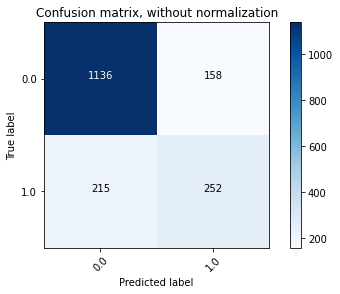

Precision: 0.6146
Recall: 0.5396
F1: 0.5747
Accuracy score: 0.7882


In [65]:
#Lista con las clases
class_temp = gbt_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(gbt_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.136 Verdaderos Negativos y 252 Verdaderos Positivos, sin embargo ha errado en 215 Falsos Negativos y 158 Falsos Positivos. El F1 Score es 0.5747.

Confusion matrix, without normalization
[[3540  340]
 [ 561  841]]


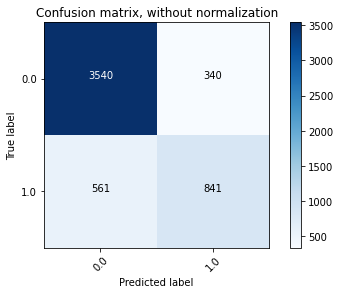

Precision: 0.7121
Recall: 0.5999
F1: 0.6512
Accuracy score: 0.8294


In [115]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
gbt_predictions_train = gbt_model.transform(train)

#Lista con las clases
class_temp = gbt_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(gbt_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting, quizás un poco.

In [66]:
#Naive Bayes Classifiers
nb=NaiveBayes(featuresCol="features", labelCol="label")
nb_model=nb.fit(train)
nb_predictions=nb_model.transform(test)
nb_predictions.select("customerID","label","prediction","rawPrediction","probability").show(10)

+----------+-----+----------+--------------------+--------------------+
|customerID|label|prediction|       rawPrediction|         probability|
+----------+-----+----------+--------------------+--------------------+
|6980-IMXXE|  0.0|       0.0|[-464.54203699227...|[1.0,1.1678531170...|
|8756-RDDLT|  0.0|       0.0|[-686.38443733550...|[1.0,2.6768771669...|
|3190-ITQXP|  0.0|       0.0|[-344.82564822544...|[0.99999999980056...|
|4672-FOTSD|  0.0|       1.0|[-471.07346313827...|[7.87907521394083...|
|2958-NHPPS|  0.0|       1.0|[-256.83808387440...|[0.26972666993024...|
|3030-YDNRM|  0.0|       1.0|[-471.60463980159...|[1.73549249207368...|
|8777-PVYGU|  0.0|       0.0|[-712.66636655129...|[1.0,6.1497541088...|
|7622-FWGEW|  0.0|       0.0|[-897.38274038065...|[1.0,1.2658175924...|
|8129-GMVGI|  0.0|       0.0|[-395.01432435010...|[0.99999999999988...|
|7315-WYOAW|  0.0|       1.0|[-613.34706762678...|[1.65739941060973...|
+----------+-----+----------+--------------------+--------------

In [67]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(nb_predictions)))

Área bajo la curva ROC en Test: 0.2847692691651875


Confusion matrix, without normalization
[[817 477]
 [119 348]]


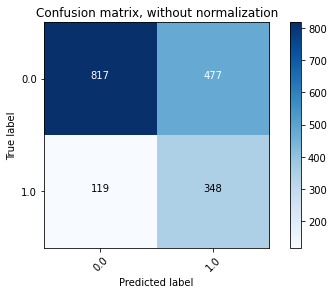

Precision: 0.4218
Recall: 0.7452
F1: 0.5387
Accuracy score: 0.6616


In [68]:
#Lista con las clases
class_temp = nb_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(nb_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 817 Verdaderos Negativos y 348 Verdaderos Positivos, sin embargo ha errado en 119 Falsos Negativos y 477 Falsos Positivos. El F1 Score es 0.5387.

Confusion matrix, without normalization
[[2430 1450]
 [ 354 1048]]


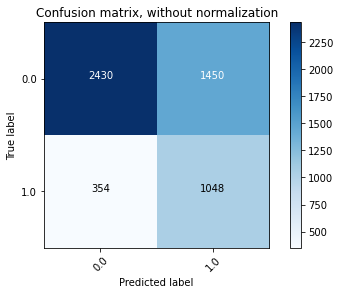

Precision: 0.4195
Recall: 0.7475
F1: 0.5374
Accuracy score: 0.6585


In [116]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
nb_predictions_train = nb_model.transform(train)

#Lista con las clases
class_temp = nb_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(nb_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [69]:
#Linear Support Vector Machine
lsvc=LinearSVC(featuresCol="features", labelCol="label")
lsvc_model=lsvc.fit(train)
lsvc_predictions=lsvc_model.transform(test)
lsvc_predictions.select("customerID","label","prediction","rawPrediction").show(10)

+----------+-----+----------+--------------------+
|customerID|label|prediction|       rawPrediction|
+----------+-----+----------+--------------------+
|6980-IMXXE|  0.0|       0.0|[3.22267496409107...|
|8756-RDDLT|  0.0|       0.0|[2.08521655351328...|
|3190-ITQXP|  0.0|       0.0|[2.57043112102680...|
|4672-FOTSD|  0.0|       0.0|[1.23233522308392...|
|2958-NHPPS|  0.0|       0.0|[1.43815044205837...|
|3030-YDNRM|  0.0|       1.0|[-0.8301176938240...|
|8777-PVYGU|  0.0|       0.0|[2.45024238781440...|
|7622-FWGEW|  0.0|       0.0|[2.72024407953844...|
|8129-GMVGI|  0.0|       0.0|[2.78940378612382...|
|7315-WYOAW|  0.0|       1.0|[-0.3991398011362...|
+----------+-----+----------+--------------------+
only showing top 10 rows



In [70]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(lsvc_predictions)))

Área bajo la curva ROC en Test: 0.6225960888574547


Confusion matrix, without normalization
[[1148  146]
 [ 216  251]]


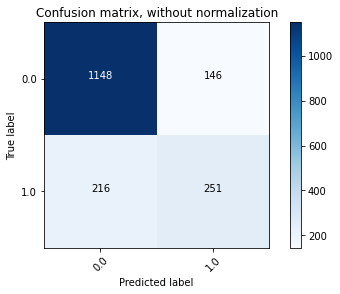

Precision: 0.6322
Recall: 0.5375
F1: 0.5810
Accuracy score: 0.7944


In [71]:
#Lista con las clases
class_temp = lsvc_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lsvc_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.148 Verdaderos Negativos y 251 Verdaderos Positivos, sin embargo ha errado en 216 Falsos Negativos y 146 Falsos Positivos. El F1 Score es 0.5810.

Confusion matrix, without normalization
[[3472  408]
 [ 619  783]]


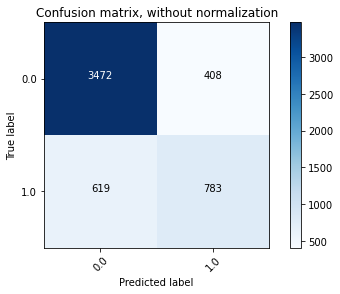

Precision: 0.6574
Recall: 0.5585
F1: 0.6039
Accuracy score: 0.8056


In [117]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
lsvc_predictions_train = lsvc_model.transform(train)

#Lista con las clases
class_temp = lsvc_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lsvc_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

<font color="Grey">Según vemos, el modelo que mejor F1 Score ha obtenido ha sido:  
**Decision Tree Classifier con F1 = 0.5902**

# <font color="grey">6. ¿Se pueden mejorar los resultado haciendo tunning de los hiperparámetros? Demuéstralo

<font color="Grey"> Si ofrecemos rangos de valores de los hiperparámetros en nuestros modelos, tendremos más posibilidades de encontrar un modelo que prediga mejor los resultados. Por ello, vamos a realizar mejoras tanto en los hiperparámetros de cada modelo, así como en la forma de entrenar, mediante Cross Validation, con lo que dividiremos nuestro train en tantas partes como elijamos ("numfolds"), utilizando todas menos una para entrar y la restante para validar resultados, después, cogerá otra parte para validar y el resto para entrenar, así hasta que la parte de validación haya sido usada en todas las partes divididas. De esta forma, el entrenamiento es más efectivo, aunque corremos el riesgo de provocar un sobreentrenamiento.  
Vamos a ver si mejoramos los modelos anteriores:

In [72]:
#Logistic Regression CV:
lr=LogisticRegression(featuresCol="features", labelCol="label")
#Añadimos rangos de hiperparámetros para el modelo:
lr_paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.1, 0.01]) 
            .addGrid(lr.fitIntercept, [False,True])
            .addGrid(lr.elasticNetParam, [0.0, 0.5])
            .addGrid(lr.maxIter, [80, 100])
            .build()
)

#CrossValidator 3 folds:
lr_cross = CrossValidator(estimator = lr,
                          estimatorParamMaps = lr_paramGrid,
                          evaluator = evaluator,
                          numFolds = 3)

#Activamos la Validación Cruzada:
lrcv_model = lr_cross.fit(train)
print(lrcv_model)

#Calculamos nuestras predicciones (en test):
lrcv_predictions = lrcv_model.transform(test)

CrossValidatorModel_483dc8a9bb0f


In [73]:
lrcv_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[4.563198732025667, -4.563198732025667]","[0.9896789871142558, 0.010321012885744186]"
1,8756-RDDLT,0.0,0.0,"[1.9157246791597267, -1.9157246791597267]","[0.871660920886294, 0.128339079113706]"
2,3190-ITQXP,0.0,0.0,"[3.73308545621575, -3.73308545621575]","[0.9766398290052155, 0.023360170994784598]"
3,4672-FOTSD,0.0,0.0,"[1.2856937679893683, -1.2856937679893683]","[0.7834174229160308, 0.21658257708396927]"
4,2958-NHPPS,0.0,0.0,"[1.6711738575751016, -1.6711738575751016]","[0.8417322640957332, 0.15826773590426682]"
5,3030-YDNRM,0.0,1.0,"[-0.7241272720763472, 0.7241272720763472]","[0.3264847777737523, 0.6735152222262477]"
6,8777-PVYGU,0.0,0.0,"[3.034624999356759, -3.034624999356759]","[0.9541140830882772, 0.04588591691172279]"
7,7622-FWGEW,0.0,0.0,"[3.9631678863215054, -3.9631678863215054]","[0.9813515530168718, 0.018648446983128113]"
8,8129-GMVGI,0.0,0.0,"[4.174960037614637, -4.174960037614637]","[0.9848570292848112, 0.015142970715188839]"
9,7315-WYOAW,0.0,1.0,"[-0.419816622087773, 0.419816622087773]","[0.3965606316916582, 0.6034393683083419]"


In [74]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(lrcv_predictions)))

Área bajo la curva ROC en Test: 0.6157080230792344


Confusion matrix, without normalization
[[1154  140]
 [ 226  241]]


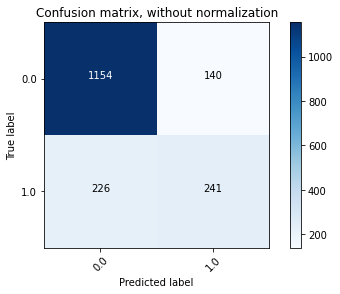

Precision: 0.6325
Recall: 0.5161
F1: 0.5684
Accuracy score: 0.7922


In [75]:
#Lista con las clases
class_temp = lrcv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lrcv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.154 Verdaderos Negativos y 241 Verdaderos Positivos, sin embargo ha errado en 226 Falsos Negativos y 140 Falsos Positivos.  
Hemos podido comprobar que los hiperparámetros por defecto del modelo son los que mejor resultado han dado. Hemos pasado de un F1 Score de 0.5878 a 0.5684 con tunning de hiperparámetros.

Confusion matrix, without normalization
[[3492  388]
 [ 638  764]]


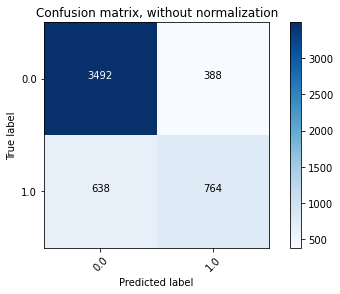

Precision: 0.6632
Recall: 0.5449
F1: 0.5983
Accuracy score: 0.8058


In [104]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
lrcv_predictions_train = lrcv_model.transform(train)

#Lista con las clases
class_temp = lrcv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lrcv_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [76]:
#Decision Tree Classifier CV:
dt=DecisionTreeClassifier(featuresCol="features",labelCol="label",seed=random_state)
#Añadimos rangos de hiperparámetros para el modelo:
dt_paramGrid = (ParamGridBuilder()
            .addGrid(dt.maxDepth, [5,10,20])
            .addGrid(dt.maxBins, [10,32,40])
            .build()
) 

#CrossValidator 3 folds:
dt_cross = CrossValidator(estimator = dt,
                          estimatorParamMaps = dt_paramGrid,
                          evaluator = evaluator,
                          numFolds = 3)

#Activamos la Validación Cruzada:
dtcv_model = dt_cross.fit(train)
print(lrcv_model)

#Calculamos nuestras predicciones (en test):
dtcv_predictions = dtcv_model.transform(test)

CrossValidatorModel_483dc8a9bb0f


In [77]:
dtcv_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[2231.0, 164.0]","[0.9315240083507307, 0.0684759916492693]"
1,8756-RDDLT,0.0,0.0,"[107.0, 40.0]","[0.7278911564625851, 0.272108843537415]"
2,3190-ITQXP,0.0,0.0,"[2231.0, 164.0]","[0.9315240083507307, 0.0684759916492693]"
3,4672-FOTSD,0.0,0.0,"[506.0, 89.0]","[0.8504201680672269, 0.1495798319327731]"
4,2958-NHPPS,0.0,0.0,"[506.0, 89.0]","[0.8504201680672269, 0.1495798319327731]"
5,3030-YDNRM,0.0,1.0,"[185.0, 364.0]","[0.33697632058287796, 0.663023679417122]"
6,8777-PVYGU,0.0,0.0,"[2231.0, 164.0]","[0.9315240083507307, 0.0684759916492693]"
7,7622-FWGEW,0.0,0.0,"[2231.0, 164.0]","[0.9315240083507307, 0.0684759916492693]"
8,8129-GMVGI,0.0,0.0,"[2231.0, 164.0]","[0.9315240083507307, 0.0684759916492693]"
9,7315-WYOAW,0.0,1.0,"[185.0, 364.0]","[0.33697632058287796, 0.663023679417122]"


In [78]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(dtcv_predictions)))

Área bajo la curva ROC en Test: 0.4153981806346546


Confusion matrix, without normalization
[[1089  205]
 [ 187  280]]


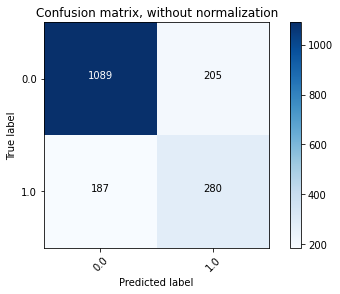

Precision: 0.5773
Recall: 0.5996
F1: 0.5882
Accuracy score: 0.7774


In [79]:
#Lista con las clases
class_temp = dtcv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(dtcv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.089 Verdaderos Negativos y 280 Verdaderos Positivos, sin embargo ha errado en 187 Falsos Negativos y 205 Falsos Positivos.  
Hemos podido comprobar que los hiperparámetros por defecto del modelo son lo que mejor resultado han dado. Hemos pasado de un F1 Score de 0.5902 a 0.5882 con tunning de hiperparámetros.

Confusion matrix, without normalization
[[3352  528]
 [ 503  899]]


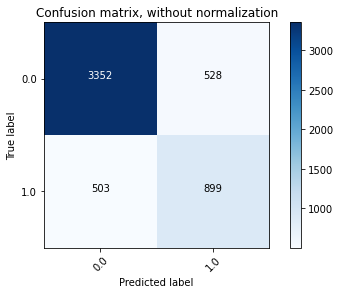

Precision: 0.6300
Recall: 0.6412
F1: 0.6356
Accuracy score: 0.8048


In [106]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
dtcv_predictions_train = dtcv_model.transform(train)

#Lista con las clases
class_temp = dtcv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(dtcv_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [80]:
#Random Forest Classifier CV:
rf = RandomForestClassifier(featuresCol="features",labelCol="label",seed=random_state)
#Añadimos rangos de hiperparámetros para el modelo:
rf_paramGrid = (ParamGridBuilder()
            .addGrid(rf.numTrees, [10,20,30])
            .addGrid(rf.maxDepth, [5,10,20])
            .addGrid(rf.maxBins, [10, 32,40])
            .build()
)  

#CrossValidator 3 folds:
rf_cross = CrossValidator(estimator = rf,
                          estimatorParamMaps = rf_paramGrid,
                          evaluator = evaluator,
                          numFolds = 3)

#Activamos la Validación Cruzada:
rfcv_model = rf_cross.fit(train)
print(rfcv_model)

#Calculamos nuestras predicciones (en test):
rfcv_predictions = rfcv_model.transform(test)

CrossValidatorModel_c55b0f6b8017


In [81]:
rfcv_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[28.095385438655814, 1.9046145613441836]","[0.936512847955194, 0.06348715204480612]"
1,8756-RDDLT,0.0,0.0,"[23.680843383567343, 6.319156616432657]","[0.7893614461189115, 0.21063855388108857]"
2,3190-ITQXP,0.0,0.0,"[28.095385438655814, 1.9046145613441836]","[0.936512847955194, 0.06348715204480612]"
3,4672-FOTSD,0.0,0.0,"[25.088698530809065, 4.911301469190944]","[0.8362899510269687, 0.16371004897303143]"
4,2958-NHPPS,0.0,0.0,"[25.790286838439638, 4.20971316156037]","[0.8596762279479877, 0.1403237720520123]"
5,3030-YDNRM,0.0,1.0,"[10.309761270679996, 19.69023872932]","[0.34365870902266654, 0.6563412909773334]"
6,8777-PVYGU,0.0,0.0,"[26.40309546969376, 3.596904530306236]","[0.8801031823231255, 0.11989681767687455]"
7,7622-FWGEW,0.0,0.0,"[28.044636479120268, 1.9553635208797342]","[0.9348212159706756, 0.06517878402932448]"
8,8129-GMVGI,0.0,0.0,"[28.095385438655814, 1.9046145613441836]","[0.936512847955194, 0.06348715204480612]"
9,7315-WYOAW,0.0,0.0,"[17.412730613063943, 12.587269386936056]","[0.5804243537687981, 0.41957564623120186]"


In [82]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(rfcv_predictions)))

Área bajo la curva ROC en Test: 0.6019617292008358


Confusion matrix, without normalization
[[1200   94]
 [ 298  169]]


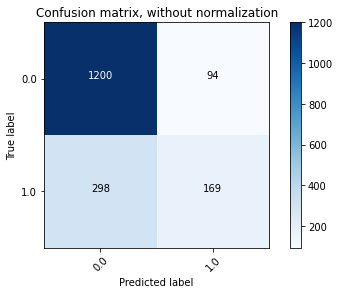

Precision: 0.6426
Recall: 0.3619
F1: 0.4630
Accuracy score: 0.7774


In [83]:
#Lista con las clases
class_temp = rfcv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(rfcv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.200 Verdaderos Negativos y 169 Verdaderos Positivos, sin embargo ha errado en 298 Falsos Negativos y 94 Falsos Positivos. 
Hemos podido comprobar que los hiperparámetros por defecto del modelo son lo que mejor resultado han dado. Hemos pasado de un F1 Score de 0.4815 a 0.4630 con tunning de hiperparámetros.

Confusion matrix, without normalization
[[3633  247]
 [ 792  610]]


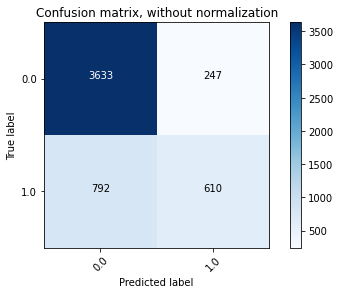

Precision: 0.7118
Recall: 0.4351
F1: 0.5401
Accuracy score: 0.8033


In [108]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
rfcv_predictions_train = rfcv_model.transform(train)

#Lista con las clases
class_temp = rfcv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(rfcv_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [96]:
#Gradient Boosting Tree Classifier CV:
gbt=GBTClassifier(featuresCol="features",labelCol="label",seed=random_state)
#Añadimos rangos de hiperparámetros para el modelo:
gbt_paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [10,20])
             .addGrid(gbt.maxBins, [10, 32])
             .addGrid(gbt.maxIter, [20,30])
             .build()
)

#CrossValidator 3 folds:
gbt_cross = CrossValidator(estimator = gbt,
                      estimatorParamMaps = gbt_paramGrid,
                      evaluator = evaluator,
                      numFolds = 3)

#Activamos la Validación Cruzada:
gbtcv_model = gbt_cross.fit(train)
print(gbtcv_model)

#Calculamos nuestras predicciones (en test):
gbtcv_predictions = gbtcv_model.transform(test)

CrossValidatorModel_4c15441611d8


In [97]:
gbtcv_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[1.6969875314253915, -1.6969875314253915]","[0.9675157096292905, 0.032484290370709545]"
1,8756-RDDLT,0.0,0.0,"[0.01761605512464059, -0.01761605512464059]","[0.5088071165571832, 0.49119288344281675]"
2,3190-ITQXP,0.0,0.0,"[1.6798821090974303, -1.6798821090974303]","[0.9664231265659653, 0.033576873434034704]"
3,4672-FOTSD,0.0,0.0,"[0.7890758897380354, -0.7890758897380354]","[0.8289426055978661, 0.17105739440213386]"
4,2958-NHPPS,0.0,0.0,"[1.7209283025376592, -1.7209283025376592]","[0.9689873570238158, 0.031012642976184224]"
5,3030-YDNRM,0.0,1.0,"[-0.24168962938139787, 0.24168962938139787]","[0.3814544806249943, 0.6185455193750057]"
6,8777-PVYGU,0.0,0.0,"[1.7256423243303158, -1.7256423243303158]","[0.9692694285256653, 0.030730571474334667]"
7,7622-FWGEW,0.0,0.0,"[1.662874297951927, -1.662874297951927]","[0.9653016529517774, 0.03469834704822261]"
8,8129-GMVGI,0.0,0.0,"[1.6987727200910483, -1.6987727200910483]","[0.9676277361226537, 0.03237226387734626]"
9,7315-WYOAW,0.0,1.0,"[-1.2254342988913052, 1.2254342988913052]","[0.07937505350681136, 0.9206249464931886]"


In [98]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(gbtcv_predictions)))

Área bajo la curva ROC en Test: 0.5399309569284177


Confusion matrix, without normalization
[[1075  219]
 [ 229  238]]


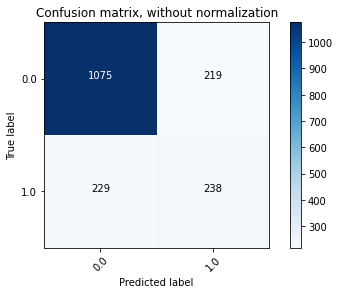

Precision: 0.5208
Recall: 0.5096
F1: 0.5152
Accuracy score: 0.7456


In [99]:
#Lista con las clases
class_temp = gbtcv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(gbtcv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.075 Verdaderos Negativos y 238 Verdaderos Positivos, sin embargo ha errado en 229 Falsos Negativos y 219 Falsos Positivos.  
Hemos podido comprobar que los hiperparámetros por defecto del modelo son lo que mejor resultado han dado, ya que hemos obtenido perores resultados, hemos pasado de un F1 Score de 0.5747 a 0.5152.

Confusion matrix, without normalization
[[3829   51]
 [  47 1355]]


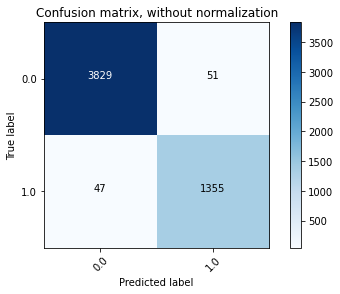

Precision: 0.9637
Recall: 0.9665
F1: 0.9651
Accuracy score: 0.9814


In [109]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
gbtcv_predictions_train = gbtcv_model.transform(train)

#Lista con las clases
class_temp = gbtcv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(gbtcv_predictions_train)

<font color="Grey">El modelo tiene overfitting ya que en train tenemos valores muy altos en la métrica y en test mucho más bajos.

In [88]:
#Naive Bayes Classifiers CV:
nb=NaiveBayes(featuresCol="features", labelCol="label")
#Añadimos rangos de hiperparámetros para el modelo:
nb_paramGrid = (ParamGridBuilder()
    .addGrid(nb.smoothing, [1, 3, 5])
    .build()
)  

#CrossValidator 3 folds:
nb_cross = CrossValidator(estimator = nb,
                      estimatorParamMaps = nb_paramGrid,
                      evaluator = evaluator,
                      numFolds = 3)

#Activamos la Validación Cruzada:
nbcv_model = nb_cross.fit(train)
print(nbcv_model)

#Calculamos nuestras predicciones (en test):
nbcv_predictions = nbcv_model.transform(test)

CrossValidatorModel_d69b4f2cb9e5


In [89]:
nbcv_predictions.select("customerID","label","prediction","rawPrediction","probability").limit(10).toPandas()

,customerID,label,prediction,rawPrediction,probability
0,6980-IMXXE,0.0,0.0,"[-464.54435510053634, -505.79852573877946]","[1.0, 1.2121080521953684e-18]"
1,8756-RDDLT,0.0,0.0,"[-686.3864224236905, -743.0016869907573]","[1.0, 2.5840624608514673e-25]"
2,3190-ITQXP,0.0,0.0,"[-344.82520204126166, -367.1142471574343]","[0.9999999997910749, 2.0892513865510259e-10]"
3,4672-FOTSD,0.0,1.0,"[-471.0591714156753, -440.86823697627074]","[7.731144123988118e-14, 0.9999999999999227]"
4,2958-NHPPS,0.0,1.0,"[-256.8330162136503, -255.83697545362827]","[0.2697205669535631, 0.7302794330464369]"
5,3030-YDNRM,0.0,1.0,"[-471.58909281414026, -423.7827984350723]","[1.7297771303213742e-21, 1.0]"
6,8777-PVYGU,0.0,0.0,"[-712.6699817123284, -761.5442512961387]","[1.0, 5.9453087432574455e-22]"
7,7622-FWGEW,0.0,0.0,"[-897.3874221435344, -970.831031160078]","[1.0, 1.270123270652222e-32]"
8,8129-GMVGI,0.0,0.0,"[-395.0150033168839, -424.7959649091717]","[0.9999999999998834, 1.1649109154100525e-13]"
9,7315-WYOAW,0.0,1.0,"[-613.3363765278194, -570.0972333022205]","[1.665247134068571e-19, 1.0]"


In [90]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(nbcv_predictions)))

Área bajo la curva ROC en Test: 0.28477213618837427


Confusion matrix, without normalization
[[817 477]
 [119 348]]


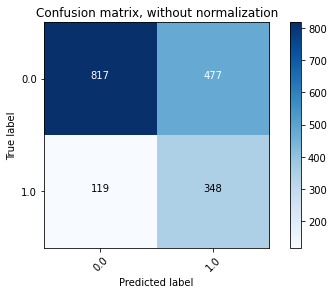

Precision: 0.4218
Recall: 0.7452
F1: 0.5387
Accuracy score: 0.6616


In [91]:
#Lista con las clases
class_temp = nbcv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(nbcv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 817 Verdaderos Negativos y 348 Verdaderos Positivos, sin embargo ha errado en 119 Falsos Negativos y 477 Falsos Positivos.  
Hemos podido comprobar que los hiperparámetros por defecto del modelo son lo que mejor resultado han dado, ya que hemos obtenido los mismos resultados, por lo que el Cross Validation no ha tenido mucho efecto. F1 Score 0.5387 en ambos casos.

Confusion matrix, without normalization
[[2430 1450]
 [ 354 1048]]


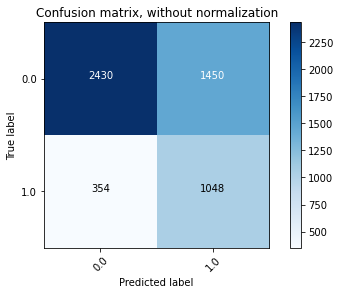

Precision: 0.4195
Recall: 0.7475
F1: 0.5374
Accuracy score: 0.6585


In [110]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
nbcv_predictions_train = nbcv_model.transform(train)

#Lista con las clases
class_temp = nbcv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(nbcv_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

In [92]:
#Linear Support Vector Machine CV:
lsvc=LinearSVC(featuresCol="features", labelCol="label")
#Añadimos rangos de hiperparámetros para el modelo:
lsvc_paramGrid = (ParamGridBuilder()
    .addGrid(lsvc.aggregationDepth, [2,3])
    .addGrid(lsvc.maxIter, [100,120])
    .addGrid(lsvc.fitIntercept, [True])
    .addGrid(lsvc.standardization, [True])
    .build()
)  

#CrossValidator 3 folds:
lsvc_cross = CrossValidator(estimator = lsvc,
                      estimatorParamMaps = lsvc_paramGrid,
                      evaluator = evaluator,
                      numFolds = 3)

#Activamos la Validación Cruzada:
lsvccv_model = lsvc_cross.fit(train)
print(lsvccv_model)

#Calculamos nuestras predicciones (en test):
lsvccv_predictions = lsvccv_model.transform(test)

CrossValidatorModel_dcf2e1cf3ecf


In [93]:
lsvccv_predictions.select("customerID","label","prediction","rawPrediction").limit(10).toPandas()

,customerID,label,prediction,rawPrediction
0,6980-IMXXE,0.0,0.0,"[3.2277585228767802, -3.2277585228767802]"
1,8756-RDDLT,0.0,0.0,"[2.0965960626182776, -2.0965960626182776]"
2,3190-ITQXP,0.0,0.0,"[2.5734640252690637, -2.5734640252690637]"
3,4672-FOTSD,0.0,0.0,"[1.241177817340986, -1.241177817340986]"
4,2958-NHPPS,0.0,0.0,"[1.4479479257474277, -1.4479479257474277]"
5,3030-YDNRM,0.0,1.0,"[-0.828524077205524, 0.828524077205524]"
6,8777-PVYGU,0.0,0.0,"[2.4630800088139075, -2.4630800088139075]"
7,7622-FWGEW,0.0,0.0,"[2.740973133720192, -2.740973133720192]"
8,8129-GMVGI,0.0,0.0,"[2.7789654248146, -2.7789654248146]"
9,7315-WYOAW,0.0,1.0,"[-0.3891190683003307, 0.3891190683003307]"


In [94]:
print("Área bajo la curva ROC en Test: " + str(evaluator.evaluate(lsvccv_predictions)))

Área bajo la curva ROC en Test: 0.6223279959507984


Confusion matrix, without normalization
[[1147  147]
 [ 218  249]]


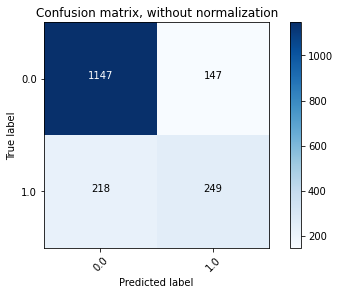

Precision: 0.6288
Recall: 0.5332
F1: 0.5771
Accuracy score: 0.7927


In [95]:
#Lista con las clases
class_temp = lsvccv_predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lsvccv_predictions)

<font color="Grey">Vemos que el modelo ha predicho correctamente 1.147 Verdaderos Negativos y 249 Verdaderos Positivos, sin embargo ha errado en 218 Falsos Negativos y 147 Falsos Positivos.  
Hemos podido comprobar que el nuevo modelo, con otros hiperparámetros y con el Cross Validation, ha empeorado los resultados, obtiendo un mejor F1 score con el modelo inical (0.5810 antes vs. 0.5771 actual).

Confusion matrix, without normalization
[[3475  405]
 [ 620  782]]


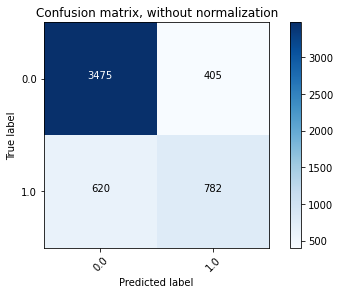

Precision: 0.6588
Recall: 0.5578
F1: 0.6041
Accuracy score: 0.8059


In [111]:
#Calculamos la matriz de las prediciones en Train para ver si hay overfitting:
lsvccv_predictions_train = lsvccv_model.transform(train)

#Lista con las clases
class_temp = lsvccv_predictions_train.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

#Matriz de confusión:
sacar_confusion_matrix(lsvccv_predictions_train)

<font color="Grey">Estamos en los mismos valores en las métricas, no hay overfitting.

<font color="Grey">Observamos, que no hemos mejorado los resultados en ningún modelo con respecto a su homólogo sin tunning.  
Por lo que el mejor modelo sigue siendo el Decision Tree Classifier sin tunear.  
Podríamos sacar los mejores parámetros de cada modelo tuneado, por al no haber mejorado los resultados anteriores no lo realizaremos.

# <font color="grey">7. En base al tipo de problemática (modelo de churn) con qué modelo te quedarías. Justificalo

<font color="Grey">Con un modelo de churn, tratamos de evitar que los clientes se den de baja de la compañía. Es importante predecir qué usuarios van a darse de baja para ofrecerle algún tipo de promoción y así hacer que cambien de opinión.

<font color="Grey">En este sentido, al analizar nuestros resultados, debemos maximizar los Verdaderos Positivos, y para ello, es necesario minimizar tanto los Falsos Positivos, es decir, usuarios que no se van a ir de la compañía, pero erróneamente se le ofrece la promoción, y los Falsos Negativos, es decir, usuarios a los que no se les ofrece ninguna promoción ya que no se les considera, pero se van de la compañía.

<font color="Grey">Para conocer qué modelo sería mejor para llevarlo a producción, vamos a hacer un ejercicio de negocio. Calcularemos el gasto anual medio de nuestros clientes, con el fin de conocer lo que podemos perder en un año porque un usuario se dé de baja (Falsos Negativos), por otro lado, calcularemos el coste de ofrecer una promoción a los usuarios que no tenían intención de irse (Falsos Positivos), en este sentido, se ofrecerá una promoción que sea una reducción del 30% en la factura, es decir, el 30% del gasto anual medio calculado anteriormente.  
La fórmula que pasaremos a todos nuestros modelos es la siguiente:

<font color="Grey">$$Falsos Negativos * Facturación Perdida + Falsos Positivos * Gasto Promoción$$

In [118]:
facturacion_perdida=df.agg(F.mean("MonthlyCharges")*12).toPandas()
facturacion_perdida=round(facturacion_perdida["(avg(MonthlyCharges) * 12)"][0],2)
facturacion_perdida

777.14

In [119]:
gasto_promocion=round(facturacion_perdida*0.3,2)
gasto_promocion

233.14

<font color="Grey">Vamos a analizar todos los modelos realizados

In [0]:
def gasto (FN,FP):
  """
  Función que determina el gasto que conlleva el uso
  del modelo.
  """
  return round((FN*facturacion_perdida)+(FP*gasto_promocion),2)

In [121]:
#Logistic Regression:
FN=211
FP=148
gasto_lr=gasto(FN,FP)
print("Con Logistic Regression la empresa perdería:",gasto_lr,"$")

#Decision Tree Classifier:
FN=184
FP=209
gasto_dt=gasto(FN,FP)
print("Con Decision Tree Classifier la empresa perdería:",gasto_dt,"$")

#Random Forest Classifier:
FN=291
FP=88
gasto_rf=gasto(FN,FP)
print("Con Random Forest Classifier la empresa perdería:",gasto_rf,"$")

#Gradient Boosting Tree Classifier:
FN=215
FP=158
gasto_gbt=gasto(FN,FP)
print("Con Gradient Boosting Tree Classifier la empresa perdería:",gasto_gbt,"$")

#Naive Bayes Classifiers:
FN=119
FP=477
gasto_nb=gasto(FN,FP)
print("Con Naive Bayes Classifiers la empresa perdería:",gasto_nb,"$")

#Linear Support Vector Machine:
FN=216
FP=146
gasto_lsvc=gasto(FN,FP)
print("Con Linear Support Vector Machine la empresa perdería:",gasto_lsvc,"$")

#Con tunning hiperparámetros y Cross Validation:
#Logistic Regression:
FN=226
FP=140
gasto_lrcv=gasto(FN,FP)
print("Con Logistic Regression CV la empresa perdería:",gasto_lrcv,"$")

#Decision Tree Classifier CV:
FN=187
FP=205
gasto_dtcv=gasto(FN,FP)
print("Con Decision Tree Classifier CV la empresa perdería:",gasto_dtcv,"$")

#Random Forest Classifier CV:
FN=298
FP=94
gasto_rfcv=gasto(FN,FP)
print("Con Random Forest Classifier CV la empresa perdería:",gasto_rfcv,"$")

#Gradient Boosting Tree Classifier CV: Sobreajustado, no lo tenemos en cuenta:
#FN=229
#FP=219
#gasto_gbtcv=gasto(FN,FP)
#print("Con Gradient Boosting Tree Classifier CV la empresa perdería:",gasto_gbtcv,"$")

#Naive Bayes Classifiers CV:
FN=119
FP=477
gasto_nbcv=gasto(FN,FP)
print("Con Naive Bayes Classifiers CV la empresa perdería:",gasto_nbcv,"$")

#Linear Support Vector Machine CV:
FN=218
FP=147
gasto_lsvccv=gasto(FN,FP)
print("Con Linear Support Vector Machine CV la empresa perdería:",gasto_lsvccv,"$")

Con Logistic Regression la empresa perdería: 198481.26 $
Con Decision Tree Classifier la empresa perdería: 191720.02 $
Con Random Forest Classifier la empresa perdería: 246664.06 $
Con Gradient Boosting Tree Classifier la empresa perdería: 203921.22 $
Con Naive Bayes Classifiers la empresa perdería: 203687.44 $
Con Linear Support Vector Machine la empresa perdería: 201900.68 $
Con Logistic Regression CV la empresa perdería: 208273.24 $
Con Decision Tree Classifier CV la empresa perdería: 193118.88 $
Con Random Forest Classifier CV la empresa perdería: 253502.88 $
Con Naive Bayes Classifiers CV la empresa perdería: 203687.44 $
Con Linear Support Vector Machine CV la empresa perdería: 203688.1 $


<font color="Grey">Vamos a crear un diccionario con todos los valores y crearemos un dataframe para ver cláramente qué modelo nos genera menos pérdidas:

In [0]:
diccionario={"gasto_lr":gasto_lr,"gasto_dt":gasto_dt,"gasto_rf":gasto_rf,
             "gasto_gbt":gasto_gbt,"gasto_nb":gasto_nb,"gasto_lsvc":gasto_lsvc,
             "gasto_lrcv":gasto_lrcv,"gasto_dtcv":gasto_dtcv,
             "gasto_rfcv":gasto_rfcv,"gasto_nbcv":gasto_nbcv,
             "gasto_lsvccv":gasto_lsvccv}

In [124]:
Pérdidas_por_modelos= pd.DataFrame([[key, diccionario[key]] for key in diccionario.keys()], columns=['Modelo', 'Pérdida'])
Pérdidas_por_modelos.sort_values(by="Pérdida").head(1)

,Modelo,Pérdida
1,gasto_dt,191720.02


<font color="Grey">Como podemos ver en la tabla, el modelo que genera menos gasto a la empresa es el Decision Tree Classifier con 191720.02 $ al año.  
Vamos a ver el coste que conllevaría no realizar ningún modelo en test, para compararlo con los resultados obtenidos anteriormente:

In [126]:
coste_sin_modelo=facturacion_perdida* test.filter(test.Churn=="Yes").count()
print("El coste en facturación perdida si no llevaramos a producción ningún modelo sería: %s $" %coste_sin_modelo)

print("El coste en facturación perdida con el modelo Decision Tree Classifier: %s $" %gasto_dt)

print("El ahorro para la empresa con el uso del modelo Decision Tree Classifier es de un:",
      round((gasto_dt/coste_sin_modelo)*100,2),"% al año.")

El coste en facturación perdida si no llevaramos a producción ningún modelo sería: 362924.38 $
El coste en facturación perdida con el modelo Decision Tree Classifier: 191720.02 $
El ahorro para la empresa con el uso del modelo Decision Tree Classifier es de un: 52.83 % al año.


<font color="Grey">Según nuestro supuesto, si llevaramos a producción el modelo Decision Tree Classifier reduciríamos las pérdidas en un 52.83%.